## MCX simulation based on package

In [1]:
! pip install pmcx
! pip install numpy pmcx jdata bjdata matplotlib
#! git clone --recursive https://github.com/fangq/mcx.git

In [2]:
from google.colab import drive
drive.mount('/content/drive')
import sys
import os

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
folder_path = '/content/drive/MyDrive/MCX_data'
if folder_path not in sys.path:
    sys.path.append(folder_path)
from MCX_sim import mcx_simulation as ms

In [4]:
pmcx.gpuinfo()

[{'name': 'NVIDIA A100-SXM4-40GB',
  'id': 1,
  'devcount': 1,
  'major': 8,
  'minor': 0,
  'globalmem': 42474471424,
  'constmem': 65536,
  'sharedmem': 49152,
  'regcount': 65536,
  'clock': 1410000,
  'sm': 108,
  'core': 6912,
  'autoblock': 64,
  'autothread': 442368,
  'maxgate': 0}]

### MCX Simulation using packgae

In [39]:
import pmcx
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pickle

In [133]:
n = 1.370
c = 2.998e+10
c = (c / n) # cm/s
ua = 0.01 # mm-1
us = 15 # mm-1
ua_cm = ua*10
us_cm = us*10

In [134]:
data, time_unit = ms(ua, us, g=0.85, n=1.370, distance = 15, tend =1e-08, devf = 1000, nphoton = 1e8)

nphoton: 1e+08
tstart: 0
tstep: 1e-11
tend: 1e-08
maxdetphoton: 1e+08
issrcfrom0: 1
autopilot: 1
unitinmm: 1
issaveref: 1
issavedet: 1


In [135]:
print(len(data))

1000


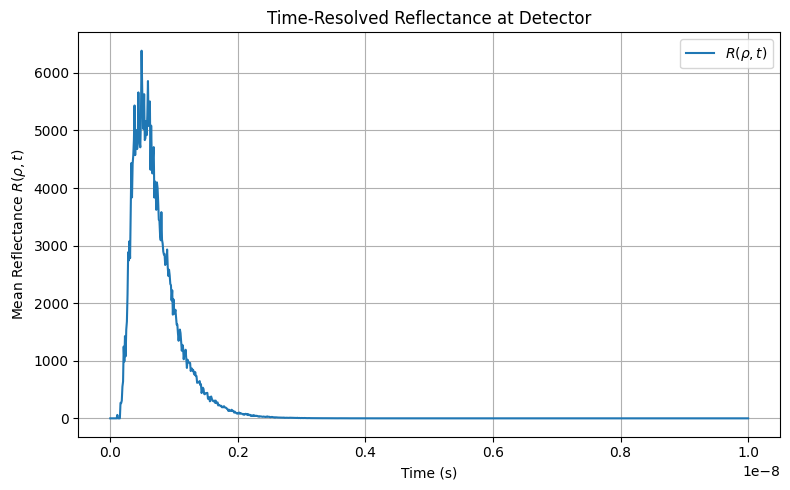

In [136]:
# Plot
times = np.linspace(0, len(data)*time_unit, len(data))
plt.figure(figsize=(8, 5))
plt.plot(times, data, label=r"$R(\rho, t)$")
plt.xlabel("Time (s)")
plt.ylabel("Mean Reflectance $R(\\rho, t)$")
plt.title("Time-Resolved Reflectance at Detector")
plt.grid(True)
#plt.xlim(0, 0.1e-8)
plt.legend()
plt.tight_layout()
plt.show()

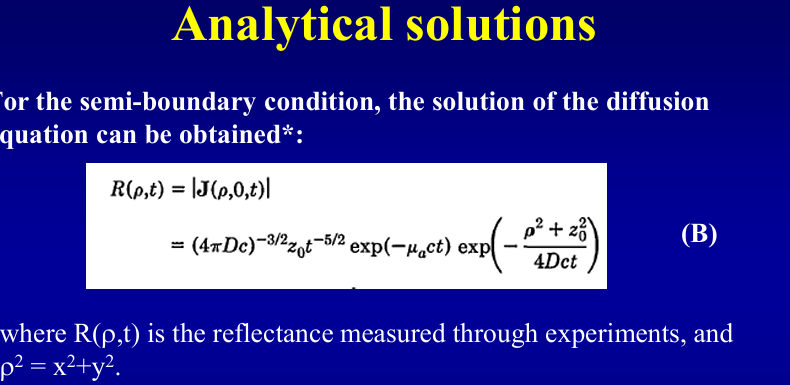

In [137]:
mean_dref_per_time_ln = [np.log(x) for x in data]
print(len(mean_dref_per_time_ln))

1000


<ipython-input-137-340a4d239aa6>:1: RuntimeWarning: divide by zero encountered in log
  mean_dref_per_time_ln = [np.log(x) for x in data]


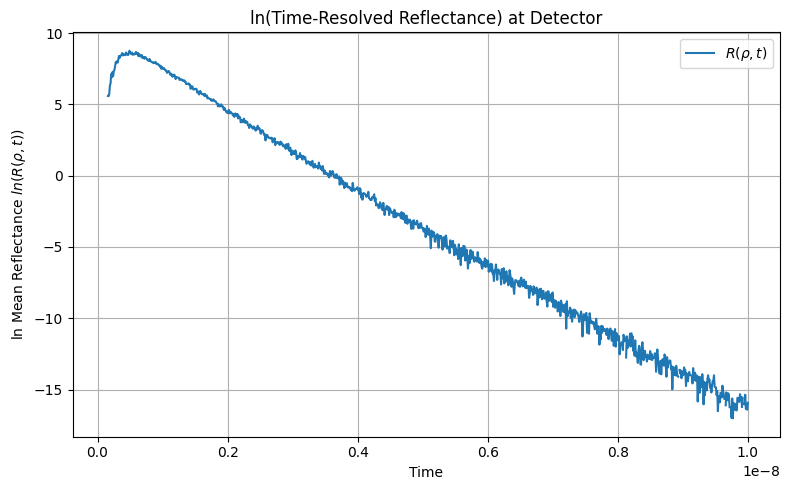

In [138]:
# Plot
plt.figure(figsize=(8, 5))
plt.plot(times, mean_dref_per_time_ln, label=r"$R(\rho, t)$")
plt.xlabel("Time")
plt.ylabel("ln Mean Reflectance $ln(R(\\rho, t))$")
plt.title("ln(Time-Resolved Reflectance) at Detector")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [139]:
def compute_slope(x1, y1, x2, y2):
  if x2 != x1:
      return (y2 - y1) / (x2 - x1)
  else:
      return None

In [140]:
ua = -(compute_slope(time_unit* 100, mean_dref_per_time_ln[100], time_unit*350, mean_dref_per_time_ln[350]))/c
print('ua=', ua,'/mm-1')
print('ua=',ua*10,'/cm-1')

ua= 0.1329864 /mm-1
ua= 1.329864 /cm-1


### MCX vs Formula

$$
R(\rho, t) = \left| \mathbf{J}(\rho, 0, t) \right| = (4\pi D c)^{-3/2} z_0 t^{-5/2} \cdot \exp(-\mu_a c t) \cdot \exp\left( -\frac{\rho^2 + z_0^2}{4 D c t} \right)
$$

In [141]:
ua = ua_cm   # cm
us = us_cm  # cm
p = 1.5 # distance (cm)
g = 0.85 # anisotropy factor unitless
D = 1/(3*(ua+us*(1-g))) # cm
# z_o:
z_o = 1/(us*(1-g))
t = np.linspace(0, 1e-08, 1000)

In [142]:
def R_rho_t(t, ua, c, D, z0, rho=p):
    # Avoid division by zero for t = 0
    #print(t)
    t = np.where(t == 0, np.finfo(float).eps, t)  # Replace 0 with a small number

    # Prefactor: (4 * pi * D * c) ** (-3/2)
    A = (4 * np.pi * D * c) ** (-1.5)

    # z0 * t ** (-5/2)
    T = z0 * (t ** (-2.5))

    # Exponential terms
    exp1 = np.exp(-ua * c * t)
    exp2 = np.exp(-(rho**2 + z0**2) / (4 * D * c * t))

    # Return the product
    return A * T * exp1 * exp2

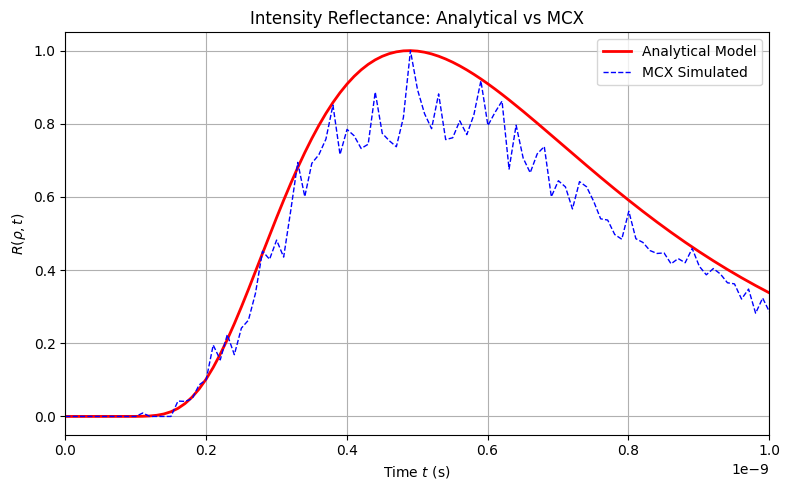

In [143]:
plt.figure(figsize=(8, 5))
intensity =  R_rho_t(t, ua, c, D, z_o)

# Plot analytical model
plt.plot(t, intensity/np.max(intensity), 'r-', label="Analytical Model", linewidth=2)

# Plot MCX simulated data
plt.plot(t, data/np.max(data), 'b--', label="MCX Simulated", linewidth=1)

# Labels and title
plt.xlabel("Time $t$ (s)")
plt.ylabel(r"$R(\rho, t)$")
plt.title("Intensity Reflectance: Analytical vs MCX")
plt.xlim(0, 1e-9)
#plt.xlim(0, 0.2e-8)

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Take Ln

$$
\ln R(\rho, t) = -\frac{3}{2} \ln(4 \pi D c) + \ln(z_0) - \frac{5}{2} \ln(t) - \mu_a c t - \frac{\rho^2 + z_0^2}{4 D c t}
$$

$$
\frac{d}{dt} \left[ \ln R(\rho, t) \right] = -\frac{5}{2t} - \mu_a c + \frac{\rho^2 + z_0^2}{4 D c t^2}
$$

In [144]:
ln_intensity = -ua * c * t - (3/2) * np.log(4 * np.pi * D * c) + np.log(z_o) - (5/2) * np.log(t) - ((p**2 + z_o**2) / (4 * D * c * t))

def get_ln_intensity(t):
    ln_intensity = -ua * c * t - (3/2) * np.log(4 * np.pi * D * c) + np.log(z_o) - (5/2) * np.log(t) - ((p**2 + z_o**2) / (4 * D * c * t))
    return ln_intensity

<ipython-input-144-93dbc2c9b041>:1: RuntimeWarning: divide by zero encountered in log
  ln_intensity = -ua * c * t - (3/2) * np.log(4 * np.pi * D * c) + np.log(z_o) - (5/2) * np.log(t) - ((p**2 + z_o**2) / (4 * D * c * t))
<ipython-input-144-93dbc2c9b041>:1: RuntimeWarning: divide by zero encountered in divide
  ln_intensity = -ua * c * t - (3/2) * np.log(4 * np.pi * D * c) + np.log(z_o) - (5/2) * np.log(t) - ((p**2 + z_o**2) / (4 * D * c * t))
<ipython-input-144-93dbc2c9b041>:1: RuntimeWarning: invalid value encountered in subtract
  ln_intensity = -ua * c * t - (3/2) * np.log(4 * np.pi * D * c) + np.log(z_o) - (5/2) * np.log(t) - ((p**2 + z_o**2) / (4 * D * c * t))


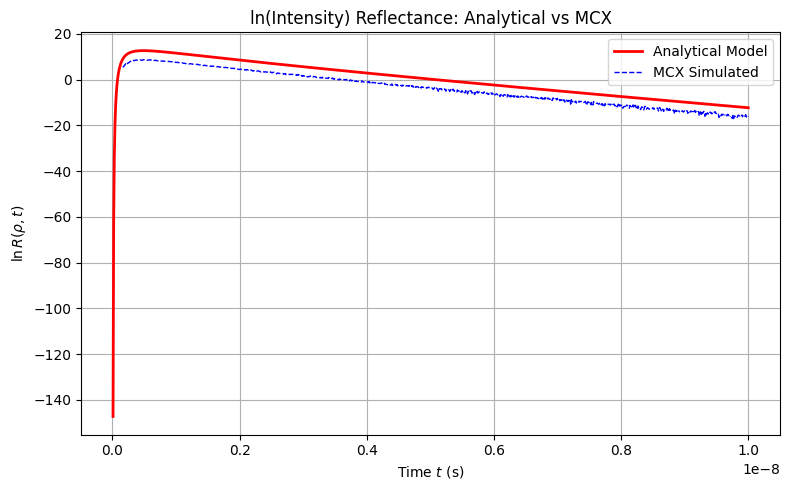

In [145]:
# Plot
plt.figure(figsize=(8, 5))

# Plot analytical model
plt.plot(t, ln_intensity, 'r-', label="Analytical Model", linewidth=2)

# Plot MCX simulated data
plt.plot(t, mean_dref_per_time_ln, 'b--', label="MCX Simulated", linewidth=1)

# Labels and title
plt.xlabel("Time $t$ (s)")
plt.ylabel(r"$\ln R(\rho, t)$")
plt.title("ln(Intensity) Reflectance: Analytical vs MCX")

# Grid and legend
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [146]:
ua_mcx = -(compute_slope(time_unit * 100, mean_dref_per_time_ln[100], time_unit*350, mean_dref_per_time_ln[350]))/(c*10)
ua_the = -(compute_slope(time_unit * 100, ln_intensity[100], time_unit*350, ln_intensity[350]))/(c*10)
print('ua_mcx=', ua_mcx,'/mm-1')
print('ua_the=',ua_the,'/mm-1')

ua_mcx= 0.013298641 /mm-1
ua_the= 0.013459634675506371 /mm-1
